<img style="float: left;;" src='Figures/iteso.jpg' width="100" height="200"/></a>

# <center> <font color= #000047> 5.- Feature Hashing </font> </center>

Feature Hashing, también conocido como el **"hashing trick"**, es una técnica para transformar variables categóricas de alta cardinalidad en un espacio de características de tamaño fijo. Es especialmente útil cuando el número de categorías posibles es muy grande o desconocido.

La **cardinalidad** de una variable categórica es el número de categorías únicas que contiene.

Se considera que una variable tiene **alta cardinalidad** cuando el número de categorías distintas es grande en relación al número de observaciones o al contexto del problema. No existe un umbral universal, pero algunas reglas prácticas son:

- Si el número de categorías es mayor a 10-20, puede considerarse moderadamente alta.
- Si hay decenas, cientos o miles de categorías únicas, es claramente alta cardinalidad.
- Si el número de categorías es comparable al número de filas (por ejemplo, un identificador único por registro), la cardinalidad es extremadamente alta.

**Ejemplos de variables de alta cardinalidad:**
- Códigos postales
- Nombres de productos
- IDs de usuario
- Direcciones de correo electrónico

**¿Por qué es importante?**
Las variables de alta cardinalidad pueden causar problemas de memoria y sobreajuste si se codifican con técnicas tradicionales como one-hot encoding. Por eso, técnicas como feature hashing son útiles en estos casos.

#### Ejemplo:

Supón que tienes 10,000 países distintos y decides usar m=100 buckets. Cada país se asigna a un bucket usando una función hash y la operación módulo. Así, solo necesitas 100 columnas para representar cualquier país, aunque pierdes la capacidad de distinguir perfectamente entre todos ellos si hay colisiones.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv('Países.csv')
df.head()

,Países
0,MEX
1,CHN
2,CAN
3,POL
4,CPV


In [2]:
len(df)

560

In [4]:
# Cardinalidad de 'Países'
df['Países'].nunique(),df['Países'].unique()

(91,
 array(['MEX', 'CHN', 'CAN', 'POL', 'CPV', 'PHL', 'EGY', 'FIN', 'ITA',
        'AUS', 'CZE', 'BLZ', 'FRA', 'RUS', 'MAR', 'ESP', 'CIV', 'AND',
        'SOM', 'CHE', 'AUT', 'BHS', 'JPN', 'PRT', 'KOR', 'COL', 'USA',
        'NLD', 'HRV', 'SWE', 'DEU', 'BEN', 'BTN', 'SEN', 'ECU', 'LCA',
        'BEL', 'NOR', 'GRC', 'TCD', 'KEN', 'IRN', 'CYP', 'ZAF', 'DNK',
        'TGO', 'PAK', 'SVK', 'LSO', 'RWA', 'ARE', 'GRD', 'MDV', 'PNG',
        'MHL', 'SVN', 'SLV', 'OMN', 'TUV', 'GNB', 'PER', 'SDN', 'GEO',
        'ALB', 'BOL', 'GMB', 'CUB', 'GIN', 'VUT', 'COG', 'SYC', 'CAF',
        'PRY', 'LBN', 'UGA', 'NER', 'TUR', 'MYS', 'SAU', 'TKL', 'EST',
        'LTU', 'GNQ', 'BLR', 'FJI', 'NIU', 'MNE', 'SMR', 'JOR', 'BIH',
        'UKR'], dtype=object))

In [5]:
df['Países'].value_counts()

Países
EGY    33
CAN    31
JPN    29
FIN    27
ITA    27
       ..
MDV     1
PNG     1
MHL     1
SVN     1
UKR     1
Name: count, Length: 91, dtype: int64

<Axes: xlabel='Países'>

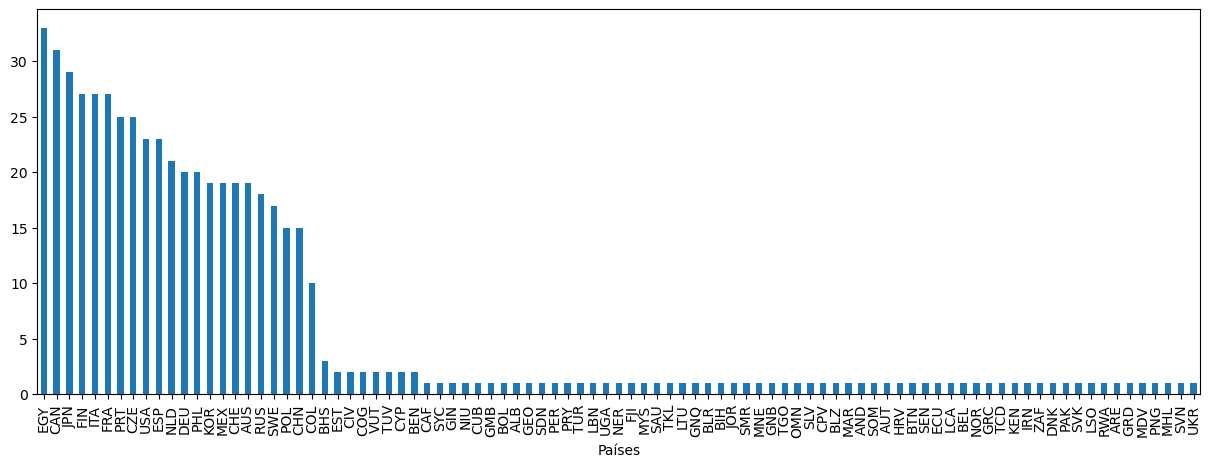

In [6]:
vc = df['Países'].value_counts()
vc.plot.bar(figsize=(15,5))

In [7]:
#Suma acumulada
sc = vc.cumsum()
sc

Países
EGY     33
CAN     64
JPN     93
FIN    120
ITA    147
      ... 
MDV    556
PNG    557
MHL    558
SVN    559
UKR    560
Name: count, Length: 91, dtype: int64

<Axes: xlabel='Países'>

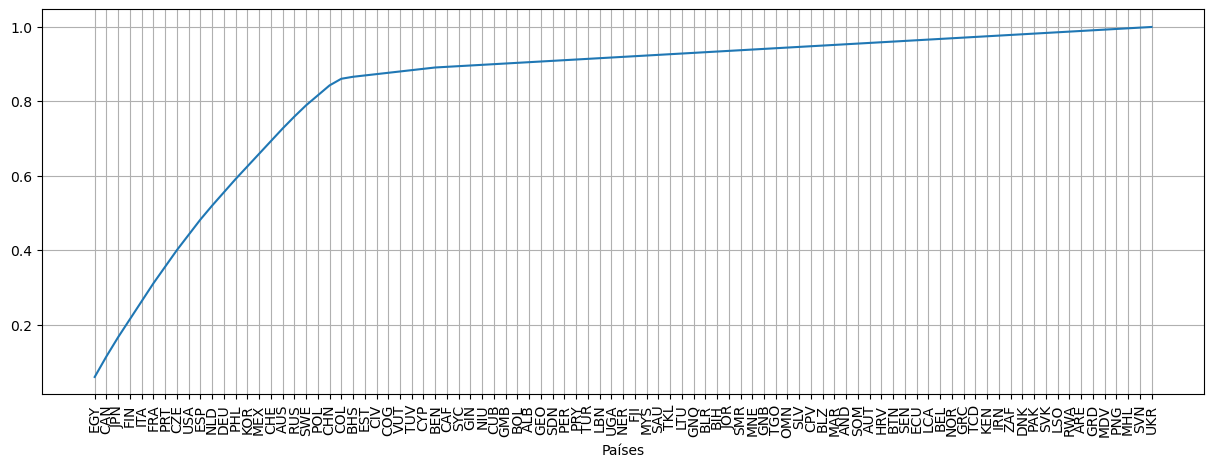

In [11]:
(sc/len(df)).plot(grid=True, figsize=(15,5), xticks=range(91), rot=90)

In [14]:
np.where(sc/len(df) > 0.80) # Apartir del indice 19 --> 20

(array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
        70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
        87, 88, 89, 90], dtype=int64),)

In [17]:
sc[19]/len(df) # Eligiendo a m (buckets, contenedores) igual a 20 para tener más del 80%

C:\Users\uie70742\AppData\Local\Temp\ipykernel_36176\2962537282.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sc[19]/len(df)


0.8160714285714286

In [18]:
m = 20

### ¿Cómo funciona Feature hashing?

1. **Definir el número de buckets (m):**
   Se elige un número fijo de columnas (buckets) donde se mapearán las categorías. Este número es mucho menor que la cantidad total de categorías posibles.

2. **Aplicar una función hash:**
   Cada categoría se transforma usando una función hash (por ejemplo, hash de Python, MurmurHash, etc.), que convierte el valor de la categoría en un número entero.

3. **Asignar a un bucket:**
   El valor hash se reduce al rango de buckets usando la operación módulo (`hash(categoría) % m`). Así, cada categoría se asigna a uno de los m buckets.

4. **Codificación:**
   Para cada observación, se crea un vector de longitud m, donde solo el bucket correspondiente a la categoría tiene un valor distinto de cero (por ejemplo, 1 o la frecuencia), y el resto son ceros. Si varias categorías caen en el mismo bucket, sus valores se suman (esto se llama colisión).

### Algunas Ventajas:
- Permite trabajar con variables categóricas de alta cardinalidad sin crear miles de columnas.
- El espacio de representación es fijo y controlable.
- Es eficiente en memoria y velocidad.

### Riegos que puede haber con es:
- Puede haber colisiones: diferentes categorías pueden terminar en el mismo bucket, perdiendo información.
- No es interpretable: no es posible saber a qué categoría corresponde cada bucket.


#### Ejemplo

In [19]:
vc

Países
EGY    33
CAN    31
JPN    29
FIN    27
ITA    27
       ..
MDV     1
PNG     1
MHL     1
SVN     1
UKR     1
Name: count, Length: 91, dtype: int64

In [22]:
#Por conteo de categorías
m = 20
key = {categorias:ids for categorias,ids in zip(vc.index, range(91))}
key

{'EGY': 0,
 'CAN': 1,
 'JPN': 2,
 'FIN': 3,
 'ITA': 4,
 'FRA': 5,
 'PRT': 6,
 'CZE': 7,
 'USA': 8,
 'ESP': 9,
 'NLD': 10,
 'DEU': 11,
 'PHL': 12,
 'KOR': 13,
 'MEX': 14,
 'CHE': 15,
 'AUS': 16,
 'RUS': 17,
 'SWE': 18,
 'POL': 19,
 'CHN': 20,
 'COL': 21,
 'BHS': 22,
 'EST': 23,
 'CIV': 24,
 'COG': 25,
 'VUT': 26,
 'TUV': 27,
 'CYP': 28,
 'BEN': 29,
 'CAF': 30,
 'SYC': 31,
 'GIN': 32,
 'NIU': 33,
 'CUB': 34,
 'GMB': 35,
 'BOL': 36,
 'ALB': 37,
 'GEO': 38,
 'SDN': 39,
 'PER': 40,
 'PRY': 41,
 'TUR': 42,
 'LBN': 43,
 'UGA': 44,
 'NER': 45,
 'FJI': 46,
 'MYS': 47,
 'SAU': 48,
 'TKL': 49,
 'LTU': 50,
 'GNQ': 51,
 'BLR': 52,
 'BIH': 53,
 'JOR': 54,
 'SMR': 55,
 'MNE': 56,
 'GNB': 57,
 'TGO': 58,
 'OMN': 59,
 'SLV': 60,
 'CPV': 61,
 'BLZ': 62,
 'MAR': 63,
 'AND': 64,
 'SOM': 65,
 'AUT': 66,
 'HRV': 67,
 'BTN': 68,
 'SEN': 69,
 'ECU': 70,
 'LCA': 71,
 'BEL': 72,
 'NOR': 73,
 'GRC': 74,
 'TCD': 75,
 'KEN': 76,
 'IRN': 77,
 'ZAF': 78,
 'DNK': 79,
 'PAK': 80,
 'SVK': 81,
 'LSO': 82,
 'RWA': 83,
 '

#### Función hash

Una función hash es una función determinista que asigna un entero potencialmente ilimitado a un rango finito de enteros [1, m]. Dado que el dominio de entrada es potencialmente mayor que el rango de salida, varios números pueden asignarse al mismo resultado. Esto se llama una colisión. Una función hash uniforme asegura que aproximadamente la misma cantidad de números se asignen a cada uno de los m contenedores.

Visualmente, podemos pensar en una función hash como una máquina que recibe bolas numeradas (claves) y las dirige a uno de los m contenedores. Las bolas con el mismo número siempre serán dirigidas al mismo contenedor. Esto mantiene el espacio de características mientras reduce el almacenamiento y el tiempo de procesamiento durante el entrenamiento y evaluación de algún algoritmo de aprendizaje automático.

Las funciones hash pueden construirse para cualquier objeto que pueda representarse numéricamente (lo cual es cierto para cualquier dato que pueda almacenarse en una computadora): números, cadenas, estructuras complejas, etc.

In [24]:
# Función Hash tomando en cuenta la frecuencia
m=20
cnt =[0]*m
for obs in df['Países']:
    i = key[obs]%m
    cnt[i]+=1
cnt

[51,
 44,
 35,
 32,
 32,
 32,
 30,
 30,
 28,
 28,
 25,
 23,
 23,
 22,
 22,
 22,
 22,
 21,
 20,
 18]

In [25]:
has_cod = {pais: cnt[ID%m] for pais, ID in key.items()}
has_cod

{'EGY': 51,
 'CAN': 44,
 'JPN': 35,
 'FIN': 32,
 'ITA': 32,
 'FRA': 32,
 'PRT': 30,
 'CZE': 30,
 'USA': 28,
 'ESP': 28,
 'NLD': 25,
 'DEU': 23,
 'PHL': 23,
 'KOR': 22,
 'MEX': 22,
 'CHE': 22,
 'AUS': 22,
 'RUS': 21,
 'SWE': 20,
 'POL': 18,
 'CHN': 51,
 'COL': 44,
 'BHS': 35,
 'EST': 32,
 'CIV': 32,
 'COG': 32,
 'VUT': 30,
 'TUV': 30,
 'CYP': 28,
 'BEN': 28,
 'CAF': 25,
 'SYC': 23,
 'GIN': 23,
 'NIU': 22,
 'CUB': 22,
 'GMB': 22,
 'BOL': 22,
 'ALB': 21,
 'GEO': 20,
 'SDN': 18,
 'PER': 51,
 'PRY': 44,
 'TUR': 35,
 'LBN': 32,
 'UGA': 32,
 'NER': 32,
 'FJI': 30,
 'MYS': 30,
 'SAU': 28,
 'TKL': 28,
 'LTU': 25,
 'GNQ': 23,
 'BLR': 23,
 'BIH': 22,
 'JOR': 22,
 'SMR': 22,
 'MNE': 22,
 'GNB': 21,
 'TGO': 20,
 'OMN': 18,
 'SLV': 51,
 'CPV': 44,
 'BLZ': 35,
 'MAR': 32,
 'AND': 32,
 'SOM': 32,
 'AUT': 30,
 'HRV': 30,
 'BTN': 28,
 'SEN': 28,
 'ECU': 25,
 'LCA': 23,
 'BEL': 23,
 'NOR': 22,
 'GRC': 22,
 'TCD': 22,
 'KEN': 22,
 'IRN': 21,
 'ZAF': 20,
 'DNK': 18,
 'PAK': 51,
 'SVK': 44,
 'LSO': 35,
 'RW

In [26]:
df['hash_1']=df['Países'].map(has_cod)
df.head()

,Países,hash_1
0,MEX,22
1,CHN,51
2,CAN,44
3,POL,18
4,CPV,44


In [27]:
# sin conteo
key2 = {categorias:ids for categorias,ids in zip(df['Países'].unique(), range(91))}
key2

{'MEX': 0,
 'CHN': 1,
 'CAN': 2,
 'POL': 3,
 'CPV': 4,
 'PHL': 5,
 'EGY': 6,
 'FIN': 7,
 'ITA': 8,
 'AUS': 9,
 'CZE': 10,
 'BLZ': 11,
 'FRA': 12,
 'RUS': 13,
 'MAR': 14,
 'ESP': 15,
 'CIV': 16,
 'AND': 17,
 'SOM': 18,
 'CHE': 19,
 'AUT': 20,
 'BHS': 21,
 'JPN': 22,
 'PRT': 23,
 'KOR': 24,
 'COL': 25,
 'USA': 26,
 'NLD': 27,
 'HRV': 28,
 'SWE': 29,
 'DEU': 30,
 'BEN': 31,
 'BTN': 32,
 'SEN': 33,
 'ECU': 34,
 'LCA': 35,
 'BEL': 36,
 'NOR': 37,
 'GRC': 38,
 'TCD': 39,
 'KEN': 40,
 'IRN': 41,
 'CYP': 42,
 'ZAF': 43,
 'DNK': 44,
 'TGO': 45,
 'PAK': 46,
 'SVK': 47,
 'LSO': 48,
 'RWA': 49,
 'ARE': 50,
 'GRD': 51,
 'MDV': 52,
 'PNG': 53,
 'MHL': 54,
 'SVN': 55,
 'SLV': 56,
 'OMN': 57,
 'TUV': 58,
 'GNB': 59,
 'PER': 60,
 'SDN': 61,
 'GEO': 62,
 'ALB': 63,
 'BOL': 64,
 'GMB': 65,
 'CUB': 66,
 'GIN': 67,
 'VUT': 68,
 'COG': 69,
 'SYC': 70,
 'CAF': 71,
 'PRY': 72,
 'LBN': 73,
 'UGA': 74,
 'NER': 75,
 'TUR': 76,
 'MYS': 77,
 'SAU': 78,
 'TKL': 79,
 'EST': 80,
 'LTU': 81,
 'GNQ': 82,
 'BLR': 83,
 '

In [28]:
# Otra función hash
m=20
cnt =[0]*m
for obs in df['Países']:
    i = key2[obs]%m
    cnt[i]+=1
cnt

[24, 21, 64, 43, 23, 33, 59, 51, 32, 40, 48, 5, 30, 21, 4, 26, 5, 4, 5, 22]

In [29]:
has_cod2 = {pais: cnt[ID%m] for pais, ID in key2.items()}
has_cod2

{'MEX': 24,
 'CHN': 21,
 'CAN': 64,
 'POL': 43,
 'CPV': 23,
 'PHL': 33,
 'EGY': 59,
 'FIN': 51,
 'ITA': 32,
 'AUS': 40,
 'CZE': 48,
 'BLZ': 5,
 'FRA': 30,
 'RUS': 21,
 'MAR': 4,
 'ESP': 26,
 'CIV': 5,
 'AND': 4,
 'SOM': 5,
 'CHE': 22,
 'AUT': 24,
 'BHS': 21,
 'JPN': 64,
 'PRT': 43,
 'KOR': 23,
 'COL': 33,
 'USA': 59,
 'NLD': 51,
 'HRV': 32,
 'SWE': 40,
 'DEU': 48,
 'BEN': 5,
 'BTN': 30,
 'SEN': 21,
 'ECU': 4,
 'LCA': 26,
 'BEL': 5,
 'NOR': 4,
 'GRC': 5,
 'TCD': 22,
 'KEN': 24,
 'IRN': 21,
 'CYP': 64,
 'ZAF': 43,
 'DNK': 23,
 'TGO': 33,
 'PAK': 59,
 'SVK': 51,
 'LSO': 32,
 'RWA': 40,
 'ARE': 48,
 'GRD': 5,
 'MDV': 30,
 'PNG': 21,
 'MHL': 4,
 'SVN': 26,
 'SLV': 5,
 'OMN': 4,
 'TUV': 5,
 'GNB': 22,
 'PER': 24,
 'SDN': 21,
 'GEO': 64,
 'ALB': 43,
 'BOL': 23,
 'GMB': 33,
 'CUB': 59,
 'GIN': 51,
 'VUT': 32,
 'COG': 40,
 'SYC': 48,
 'CAF': 5,
 'PRY': 30,
 'LBN': 21,
 'UGA': 4,
 'NER': 26,
 'TUR': 5,
 'MYS': 4,
 'SAU': 5,
 'TKL': 22,
 'EST': 24,
 'LTU': 21,
 'GNQ': 64,
 'BLR': 43,
 'FJI': 23,


In [30]:
df['hash_2']=df['Países'].map(has_cod2)
df.head()

,Países,hash_1,hash_2
0,MEX,22,24
1,CHN,51,21
2,CAN,44,64
3,POL,18,43
4,CPV,44,23


### Función hash simple (basado en el módulo)

### Usando librerías

#### FeatureHasher de scikit-learn

`FeatureHasher` es una clase de scikit-learn (`sklearn.feature_extraction.FeatureHasher`) que implementa la técnica de **feature hashing** (hashing trick) para transformar variables categóricas (o texto) en un espacio de características de tamaño fijo. Es especialmente útil para datos de alta cardinalidad y/o cuando el espacio de posibles categorías es muy grande o desconocido.

##### Funcionamiento

1. **Entrada esperada**:
   - Recibe una lista de diccionarios, una matriz dispersa o un DataFrame donde cada fila representa una muestra y cada columna una característica categórica o de texto.
   - Cada valor puede ser una cadena, un número o una lista de tokens (en el caso de texto).

2. **Proceso de hashing**:
   - Para cada par `(característica, valor)` en cada muestra, se calcula un hash usando una función hash rápida (por defecto, MurmurHash3 de 32 bits).
   - El hash se reduce al rango `[0, n_features-1]` usando la operación módulo, donde `n_features` es el número de columnas de salida (buckets).

3. **Asignación de valores**:
   - Si el valor es numérico, se suma ese valor en el bucket correspondiente.
   - Si el valor es categórico (cadena), se suma 1 en el bucket correspondiente.
   - Para evitar que los buckets sean siempre positivos (y reducir colisiones), el signo del valor se determina usando el hash (puede ser +1 o -1).

4. **Salida**:
   - Devuelve una matriz dispersa (`scipy.sparse`) de tamaño `(n_samples, n_features)`, donde cada fila es la representación hash de la muestra original.

##### argumentos de entrada principales

- `n_features`: Número de columnas (buckets) de salida. Controla la dimensionalidad y la probabilidad de colisiones.
- `input_type`: Tipo de entrada. Puede ser `'dict'`, `'pair'`, o `'string'`.
- `alternate_sign`: Si es `True` (por defecto), alterna el signo de los valores para reducir el sesgo por colisiones.

`FeatureHasher` de scikit-learn es una herramienta poderosa para convertir variables categóricas o texto en vectores numéricos de tamaño fijo, usando hashing eficiente y controlando la dimensionalidad, a costa de perder interpretabilidad y permitir colisiones controladas.

In [ ]:
## Ejemplo de uso
from sklearn.feature_extraction import FeatureHasher

# Supón que tienes una lista de diccionarios con variables categóricas
data = [
    {'color': 'red', 'shape': 'circle'},
    {'color': 'blue', 'shape': 'square'},
    {'color': 'green', 'shape': 'triangle'},
    {'color': 'red', 'shape': 'square'}
]
data_df = pd.DataFrame(data)
data_df

In [ ]:
# Crear el hasher con 8 buckets

# Transformar los datos

# X es una matriz dispersa (sparse matrix)



**MurmurHash3** es una función hash no criptográfica, rápida y eficiente, ampliamente utilizada para aplicaciones como hash tables y feature hashing. La versión de 32 bits produce un entero de 32 bits a partir de una cadena o secuencia de bytes.

- **No criptográfica:** No es segura para aplicaciones de seguridad, pero es muy rápida y tiene baja tasa de colisiones para uso general.
- **Determinística:** La misma entrada y semilla siempre producen el mismo hash.
- **Uniformidad:** Distribuye los valores de hash de manera uniforme, lo que es ideal para hashing en estructuras de datos y machine learning.

En scikit-learn y otras librerías, MurmurHash3 se usa internamente para convertir cadenas en índices de buckets de manera eficiente y reproducible.


In [ ]:
from sklearn.utils.murmurhash import murmurhash3_32

# Ejemplo: obtener el hash de una cadena
valor = "Mexico"
hash_val = murmurhash3_32(valor, seed=0)
print(hash_val)

In [ ]:
help(murmurhash3_32)

In [ ]:
# Función hash MurmurHash3 de 32 bits


In [ ]:
#!pip install category-encoders

#### Category Encoders

In [ ]:
#Usando category_encoders para dataset de países
